# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [141]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# create copy of data to maintain original data
azdias_original = azdias.copy()
feat_info_original = feat_info.copy()

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Exploring General Demographics Data :-')
print('Data Structure : {} rows, {} columns'.format(azdias.shape[0], azdias.shape[1]))
print('First few rows ....')
azdias.head()

Exploring General Demographics Data :-
Data Structure : 891221 rows, 85 columns
First few rows ....


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Exploring Feature Summary File :-')
print('Data Structure : {} rows, {} columns'.format(feat_info.shape[0], feat_info.shape[1]))
print('First few rows ....')
feat_info.head()

Exploring Feature Summary File :-
Data Structure : 85 rows, 4 columns
First few rows ....


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

`feat_info['missing_or_unknown']` documents codes that indicate if demographic column data is missing or unknown
`feat_info['missing_or_unknown']` column  is read in as a string object
- parse `missing / unknown` codes to identify and clean the data
- see how much data takes on a `missing / unknown` code 
- see how much data is naturally missing -- as a point of interest
- convert data that matches `missing / unknown` codes into a numpy NaN value


In [6]:
# we see that originally missing/unknown column is a string object 
feat_info_original['missing_or_unknown'][1]

'[-1,0,9]'

In [7]:
# First - we'll parse the missing/unknown values - http://bit.ly/2IvCs3F
# by converting them into list of codes
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x : x[1:-1].split(','))
feat_info['missing_or_unknown'][1]

['-1', '0', '9']

In [8]:
# get longest and shortest sequence of missing or unknown codes - http://bit.ly/2ZCKbCM
field_length = feat_info['missing_or_unknown'].map(len)
col_min = field_length.idxmin()
col_max = field_length.idxmax()

print('Get Sample of missing/unknown codes ....')
print('Shortest sequence : ', feat_info.loc[col_min, 'missing_or_unknown'],
      ' - at index: ', col_min)
print('Longest sequence : ', feat_info.loc[col_max, 'missing_or_unknown'],
     ' - at index: ', col_max)

Get Sample of missing/unknown codes ....
Shortest sequence :  ['0']  - at index:  3
Longest sequence :  ['-1', '0', '9']  - at index:  1


In [9]:
# get value counts for column with longest sequence of missing/unknown values
# we see it has 2881 missing/unknown records - ie ['-1', '0', '9']
azdias.iloc[:, col_max].value_counts()

3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [10]:
# confirm we get a similar count of missing/unknown values
mask = azdias.iloc[:, col_max].isin(feat_info.loc[col_max, 'missing_or_unknown'])
print(f'Confirm number of missing values before converting to NaNs..:{mask.sum()}')

# azdias.loc[mask, 'ALTERSKATEGORIE_GROB']
# convert missing/unknown data to NaNs
azdias.loc[mask, feat_info.loc[col_max, 'attribute']] = np.nan
print(f'Confirm number of missing values after converting to NaNs..:{azdias.iloc[:, col_max].isnull().sum() }')
print(f'Proceeding to convert the entire dataframe')                                           

Confirm number of missing values before converting to NaNs..:2881
Confirm number of missing values after converting to NaNs..:2881
Proceeding to convert the entire dataframe


In [11]:
# convert missing/unknown data to NaNs 
#TODO:use pandas dataframe apply
for col in range(feat_info.shape[0]):
    mask = azdias.iloc[:, col].isin(feat_info.loc[col, 'missing_or_unknown'])
    azdias.loc[mask, feat_info.loc[col, 'attribute']] = np.nan    

In [12]:
# azdias.isnull().all(1).sum() # rows with only Nans - http://bit.ly/31XWWtC
# we can now see that some columns have null/Nans value
azdias.isnull().sum(axis=0).head()


AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

##### Notes : how much data is present in each column
- column outliers in terms of proportion of missing values
- use matplotlib 'hist' to visualize the distribution of missing value counts to find these columns
- identify and document the columns - with justifications for keeping/re-encoding the data (for now we remove/drop them)

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# get proportion of NaNs on each column 
perc_nans = azdias.isnull().mean().sort_values(ascending=False)
perc_nans[:10]

TITEL_KZ          0.997576
AGER_TYP          0.769554
KK_KUNDENTYP      0.655967
KBA05_BAUMAX      0.534687
GEBURTSJAHR       0.440203
ALTER_HH          0.348137
REGIOTYP          0.177357
KKK               0.177357
W_KEIT_KIND_HH    0.166051
KBA05_ANTG4       0.149597
dtype: float64

In [14]:
# how many columns dont have any missing data - out of the 65 columns
(perc_nans == 0).sum()

24

In [15]:
# since were interested in dropping outlier columns (ie with high percentage of NaNs)
# we can remove the 24 columns from our plot
high_perc_nans = perc_nans[perc_nans != 0]

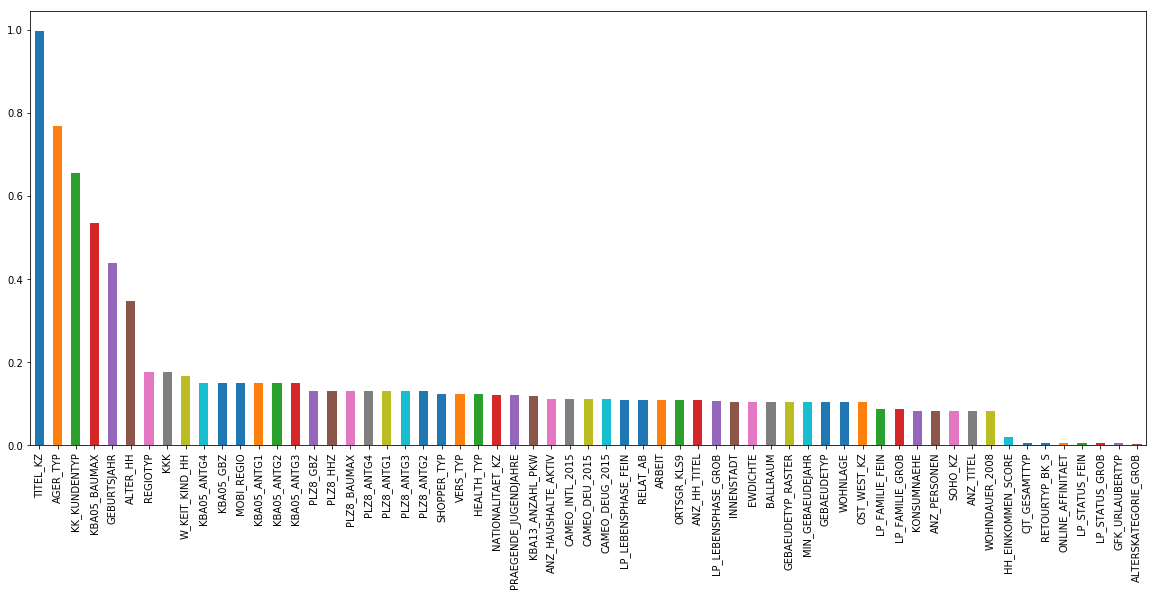

In [16]:
# Investigate patterns in the amount of missing data in each column.

# lets compare the columns and find out outlier columns (in terms of missing data)
# outlier columns - will have the highest percentage of NaNs

# we are using a barplot as we are investigating categorical data
# plt.bar(high_perc_nans.index, highest_perc_nans) #TODO find out how to use matplotlib plt to create similar
high_perc_nans.plot(kind='bar', figsize=(20, 8));

In [17]:
# From out plot we can see that roughly a minority of the column - has more than 20% of the data missing
# below is the list of columns with more than 20% missing data
highest_perc_nans = high_perc_nans[high_perc_nans > 0.2]
highest_perc_nans

TITEL_KZ        0.997576
AGER_TYP        0.769554
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
GEBURTSJAHR     0.440203
ALTER_HH        0.348137
dtype: float64

In [18]:
highest_perc_nans.index # 6 Columns to drop - have over 30% of their data missing

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(highest_perc_nans.index, axis=1, inplace=True) # http://bit.ly/2J7xFpn

In [20]:
any(azdias.columns.isin(highest_perc_nans.index)) # verify the 6 columns have been dropped

False

In [21]:
# create copy of modified data - ie data with 20% of its column data reported missing
azdias_dropna_cols = azdias.copy()
any(azdias_dropna_cols.columns.isin(highest_perc_nans.index))  # verify the 6 columns have been dropped

False

#### Discussion 1.1.2: Assess Missing Data in Each Column

Out of 85 columns - 24 columns did not have missing data.A majority of the other 61 columns have around 20% of its data missing - with exception of 6 columns - namely `'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR' and 'ALTER_HH'` that have over 30% of its data missing. These 6 columns were dropped/ removed form the `azdias` dataset

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [22]:
# How much data is missing in each row of the dataset?
azdias_dropna_cols['row_nans_perc'] = np.round(azdias_dropna_cols.isnull().mean(axis=1), 1)

In [23]:
# Below we see that a majority of the data ie 87% has atmost than 10% of its row data marked as missing or Nans
# we'll use 10% as threshold to separate our data in to 2 subsets (ie one at most 10% missing row data 
# and the other with more than 10% missing data)
azdias_dropna_cols['row_nans_perc'].value_counts(normalize=True).sort_index() #http://bit.ly/2J6Yqdu

0.0    0.768050
0.1    0.108590
0.2    0.017725
0.3    0.001085
0.4    0.020134
0.5    0.032543
0.6    0.051873
Name: row_nans_perc, dtype: float64

In [24]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
#TODO - separate the azdias data into the 2 subsets
azdias_min_nans = azdias_dropna_cols[azdias_dropna_cols['row_nans_perc'] <= 0.1] # azdias data within our threshold
azdias_max_nans = azdias_dropna_cols[azdias_dropna_cols['row_nans_perc'] > 0.1]


In [25]:
# TODO: convert this into a function - with column name argument
def sub_count_plots(col_name):
    '''View distributions of azdias features for data with many missing values 
    and for the data with few or no missing values'''
    sns.set(style="darkgrid")
    #plot the seaborn countplots side by side for the 2 data subsets
    # seaborn countplot() - http://bit.ly/2J5i61p 
    # subplot sns countplot() - http://bit.ly/2J5jWPR
    print(f'Comparing Distribution of column : {col_name}')
    fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    sns.countplot(x=col_name, data=azdias_max_nans, ax=ax[1]).set_title('Data with many missing values')
    sns.countplot(x=col_name, data=azdias_min_nans, ax=ax[0]).set_title('Data with few or no missing value')
    # fig.show() # http://bit.ly/2XlAmYi

In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# In order to know what to do with the outlier rows, we should see 
# if the distribution of data values on columns that are not missing data 
# (or are missing very little data) are similar or different between the two groups.

# Let's now see distribution of the data on some columns (on both data subsets) - 
# so as to know how different or similar they are on the 2 groups 
# and the implications of using dataset with lesser missing data has on our analysis
# PS if they are similar -dropping these nan points wont have a major issue
#    if they are different - we should note the data as special and will need revisiting later on

#TODO shorten this

Comparing Distribution of column : ALTERSKATEGORIE_GROB


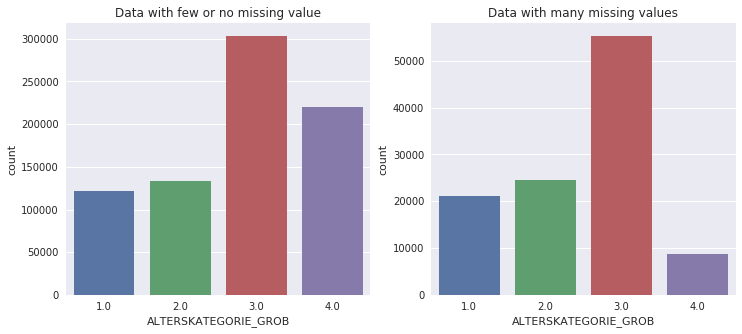

In [27]:
# Select at least five of these columns and compare the distribution of values.
col_name = 'ALTERSKATEGORIE_GROB'
sub_count_plots(col_name=col_name) 

Comparing Distribution of column : GREEN_AVANTGARDE


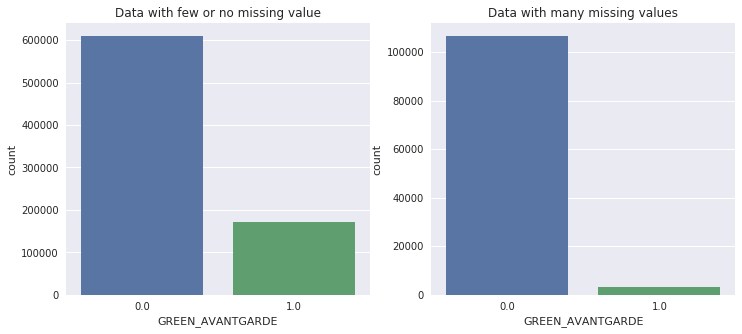

In [28]:
col_name = 'GREEN_AVANTGARDE'
sub_count_plots(col_name=col_name)

Comparing Distribution of column : ONLINE_AFFINITAET


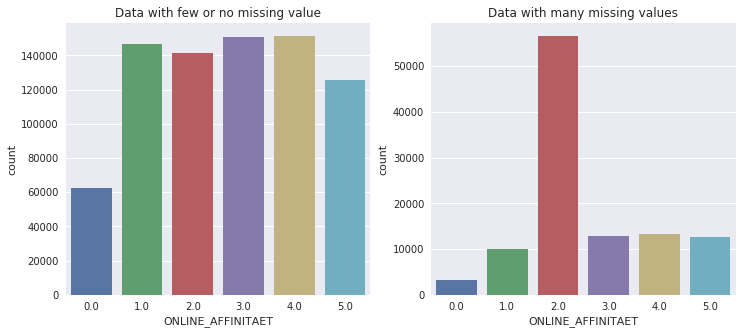

In [29]:
col_name = 'ONLINE_AFFINITAET'
sub_count_plots(col_name=col_name)

Comparing Distribution of column : ZABEOTYP


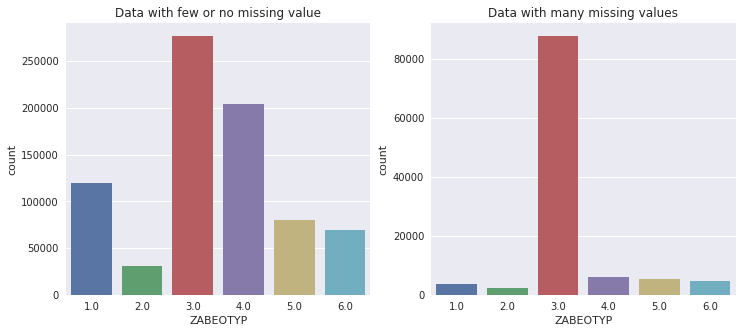

In [30]:
col_name = 'ZABEOTYP'
sub_count_plots(col_name=col_name)

Comparing Distribution of column : SEMIO_RAT


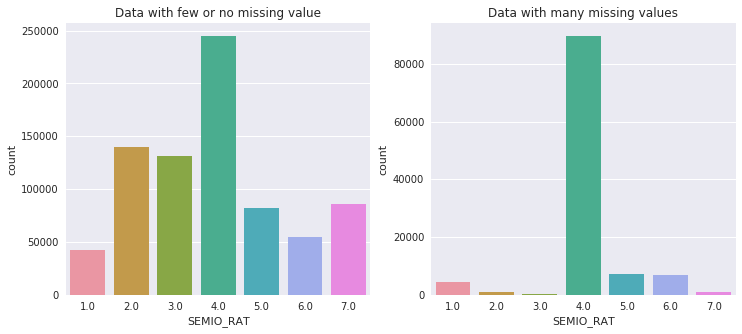

In [31]:
col_name = 'SEMIO_RAT'
sub_count_plots(col_name=col_name)

In [32]:
# create copy of modified data - with 10% or less nan observations value
azdias_dropna = azdias_min_nans.copy()

#### Discussion 1.1.3: Assess Missing Data in Each Row

13% of the observations had over 10% missing values - so we used 10% as threshold on separating the `azdias` dataset into a group with lots of missing values and another with atmost 10% of its observations missing.

We then proceed to compare the distributions of 5 columns, namely `'SEMIO_RAT', 'ZABEOTYP', 'ONLINE_AFFINITAET', 'GREEN_AVANTGARDE' and 'ALTERSKATEGORIE_GROB'` and saw that their distributions are dissimilar - implying proceeding with analysis without the missing data will most likely affect our analysis conclusion, that is the missing data is special and will need to be reviewed later on .

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
# How many features are there of each data type?

# let's see the value_counts() on the third column, type, on feat_info
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# list of columns previously dropped
dropped_cols = highest_perc_nans.index
dropped_cols

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

In [35]:
# get all categorical features (not including the dropped columns)
# pandas series logical 'and' - http://bit.ly/2XgH6Xb
# pandas series logical 'not' - http://bit.ly/2XlmuNu
mask = (feat_info['type'] == 'categorical') & ~(feat_info['attribute'].isin(dropped_cols))
cat_features = feat_info.loc[mask, 'attribute'] # features lise with categorical data
cat_features.head()

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
Name: attribute, dtype: object

In [36]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binary_numeric, binary_non_numeric = [],[]
multi_level = []

for i in range(cat_features.shape[0]):
    cat_feature = cat_features.iloc[i]
    unique_cat_values = azdias_dropna.loc[:, cat_feature].unique()
    unique_count = unique_cat_values.size
    if (unique_count == 2) and azdias_dropna.loc[:, cat_feature].dtype == np.object:
        binary_non_numeric.append(cat_feature)
    elif unique_count == 2:
        binary_numeric.append(cat_feature)
    else:
        multi_level.append(cat_feature)
    

In [37]:
def describe_category(cat_features):
    '''Describe the azidias list of features'''
    for i in range(len(cat_features)):
        cat_feature = cat_features[i]
        unique_cat_values = azdias_dropna.loc[:, cat_feature].unique()
        unique_count = unique_cat_values.size
        print('Feature : {} - {}'.format(i+1, cat_feature))
        print('Unique value count : {}'.format(unique_count))
        print('Unique values : {}'.format(unique_cat_values))
        print('_'*50)

In [38]:
# we are now going to describe the categorical featues and state the actions we will perform on them
type_action = 'Categorical Variable Type: {}\nAction : {}\nNumber of Features: {}\n{}'

In [39]:
print(type_action.format('Binary, Numeric', 'keep features, without modification', len(binary_numeric),'*'*100))
describe_category(binary_numeric)
#azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)

Categorical Variable Type: Binary, Numeric
Action : keep features, without modification
Number of Features: 3
****************************************************************************************************
Feature : 1 - ANREDE_KZ
Unique value count : 2
Unique values : [ 2.  1.]
__________________________________________________
Feature : 2 - GREEN_AVANTGARDE
Unique value count : 2
Unique values : [ 0.  1.]
__________________________________________________
Feature : 3 - SOHO_KZ
Unique value count : 2
Unique values : [ 1.  0.]
__________________________________________________


In [40]:
print(type_action.format('Binary, Non-Numeric', 're-encode them as numeric variables', len(binary_non_numeric), '*'*100))
describe_category(binary_non_numeric)

Categorical Variable Type: Binary, Non-Numeric
Action : re-encode them as numeric variables
Number of Features: 1
****************************************************************************************************
Feature : 1 - OST_WEST_KZ
Unique value count : 2
Unique values : ['W' 'O']
__________________________________________________


In [41]:
print(type_action.format('Multi-level', 'keep and create dummy variables OR Drop', len(multi_level), '*'*100))
describe_category(multi_level)

Categorical Variable Type: Multi-level
Action : keep and create dummy variables OR Drop
Number of Features: 14
****************************************************************************************************
Feature : 1 - CJT_GESAMTTYP
Unique value count : 7
Unique values : [  5.   3.   2.   4.   1.   6.  nan]
__________________________________________________
Feature : 2 - FINANZTYP
Unique value count : 6
Unique values : [ 1.  6.  5.  2.  4.  3.]
__________________________________________________
Feature : 3 - GFK_URLAUBERTYP
Unique value count : 13
Unique values : [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.  nan]
__________________________________________________
Feature : 4 - LP_FAMILIE_FEIN
Unique value count : 12
Unique values : [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
__________________________________________________
Feature : 5 - LP_FAMILIE_GROB
Unique value count : 6
Unique values : [  3.   1.  nan   5.   2.   4.]
_____________________

In [42]:
# we are going to be dropping CAMEO_DEU_2015, LP_FAMILIE_FEIN and LP_STATUS_FEIN
# as their information has been captured at a rougher scale by CAMEO_DEUG_2015 and LP_STATUS_GROB
multi_level_drop = ['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']
multi_level_keep = [x for x in multi_level if x not in multi_level_drop] #http://bit.ly/2XtgabZ

In [43]:
# Re-encode categorical variable(s) to be kept in the analysis :

# Re-encode binary non-numeric categorical variables ie OST_WEST_KZ as numeric variable
azdias_dropna.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)

# Re-encode multi-level categorical variables to keep with dummy variables
azdias_dropna = pd.get_dummies(azdias_dropna, columns=multi_level_keep) #TODO see if we can do this inplace

# Drop the multi-level categorical variable CAMEO_DEU_2015, LP_FAMILIE_FEIN and LP_STATUS_FEIN
azdias_dropna.drop(columns=multi_level_drop, axis=0, inplace=True)

In [44]:
# create copy of modified data - with re-encoded and dropped categorical variables
azdias_cat = azdias_dropna.copy()

#### Discussion 1.2.1: Re-Encode Categorical Features

Binary non-numerical feature `OST_WEST_KZ` was converted to numeric values

Binary numeric categorical varibles `ANREDE_KZ`, `GREEN_AVANTGARDE`, `SOHO_KZ` were not modified

Multi-level categorical feature `CJT_GESAMTTYP,  FINANZTYP, GFK_URLAUBERTYP, NATIONALITAET_KZ, SHOPPER_TYP, VERS_TYP
ZABEOTYP and GEBAEUDETYP` were encoded with dummy variables

Though, we considered the number of dummy variables created at this point and on studying the Azdias data dictionary we 
found out that :

For `LP_FAMILIE_FEIN and LP_FAMILIE_GROB` - describe the family type (`LP_FAMILIE_FEIN`
with fine scalea and `LP_FAMILIE_GROB` a rougher scale) , hence we decided to drop `LP_FAMILIE_FEIN`
and re-encode `LP_FAMILIE_GROB` with dummy variables

For `CAMEO_DEUG_2015 and CAMEO_DEU_2015` - both describe German CAMEO - wealth or life 
stage typology (`CAMEO_DEU_2015` with rough scale and `CAMEO_DEU_2015` a more detailed scale) ,
hence we decided to drop `CAMEO_DEU_2015` and re-encode `CAMEO_DEU_2015` with dummy variables

For `LP_STATUS_FEIN and LP_STATUS_GROB` - both describe social status
(`LP_STATUS_GROB` with rough scale and `LP_STATUS_FEIN` a fine scale) ,
hence we decided to drop `LP_STATUS_FEIN` and re-encode `LP_STATUS_GROB` with dummy variables


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [45]:
# get all mixed features (not including the dropped columns)
mask = (feat_info['type'] == 'mixed') & ~(feat_info['attribute'].isin(dropped_cols))
mixed_features = feat_info.loc[mask, 'attribute'] # features lise with categorical data
mixed_features

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [46]:
# Investigate PRAEGENDE_JUGENDJAHRE
# we will separate into 2 columns based on 
# generation data 
# (1, 2) => 40s, (3, 4) => 50s, (5, 6, 7) => 60s, (8, 9) => 70s, (10, 11, 12, 13) => 80s, (14, 15) => 90s
# movement data
# (1, 3, 5, 8, 10, 12, 14) => Mainstream
# (2, 4, 6, 7, 9, 11, 13, 15) => Avantgarde
# ( -1, 0) => unknown 
azdias_cat.loc[:, 'PRAEGENDE_JUGENDJAHRE'].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [47]:
# map of the generation data
gen_dict = {0: [1, 2], 
            1: [3, 4],
            2: [5, 6, 7],
            3: [8, 9],
            4: [10, 11, 12, 13], 
            5:[14, 15]}

def map_gen(x):
    '''Convert 'PRAEGENDE_JUGENDJAHRE' column into 
    interval-type column for generation decade'''
    try:
        for key, array in gen_dict.items():
            if x in array:
                return key
    except ValueError:
        return np.nan

In [48]:
# map of movement data
mainstream = [1, 3, 5, 8, 10, 12, 14]

def map_mov(x):
    '''
    Convert 'PRAEGENDE_JUGENDJAHRE' column into 
    binary column for movement'''
    try:
        if x in mainstream:
            return 0
        else:
            return 1
    except ValueError:
        return np.nan

In [49]:
# Engineer two new variables: the generation and movement columns from PRAEGENDE_JUGENDJAHRE
azdias_cat['PRAEGENDE_JUGENDJAHRE_GENERATION'] = azdias_cat['PRAEGENDE_JUGENDJAHRE'].apply(map_gen)
azdias_cat['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_cat['PRAEGENDE_JUGENDJAHRE'].apply(map_mov)

In [50]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# create wealth and life stage features by breaking it as :
# wealth feature :  'tens'-place digit
# life stage feature : 'ones'-place digit
azdias_cat.loc[:, 'CAMEO_INTL_2015'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [51]:
def map_wealth(x):
    '''Generate wealth feature - from CAMEO_INTL_2015 column '''
    try:
        if pd.isnull(x): # check if value is nan before getting the first index
            return np.nan
        else:
            return int(str(x)[0])
    except ValueError:
        return np.nan

In [52]:
def map_lifestage(x):
    '''Generate Life stage feature - from CAMEO_INTL_2015 column '''
    try:
        if pd.isnull(x): # check if value is nan before getting the second index
            return np.nan
        else:
            return int(str(x)[1])
    except ValueError:
        return np.nan

In [53]:
# Engineer two new variables: the wealth and life stage columns from CAMEO_INTL_2015
azdias_cat['CAMEO_INTL_2015_WEALTH'] = azdias_cat['CAMEO_INTL_2015'].apply(map_wealth)
azdias_cat['CAMEO_INTL_2015_LIFESTAGE'] = azdias_cat['CAMEO_INTL_2015'].apply(map_lifestage)

In [54]:
#TODO drop the other mixed variables 
# including the original 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'
azdias_cat.drop(columns=mixed_features, axis=0, inplace=True)

In [68]:
# create copy of modified data - with re-encoded and dropped mixed-value variables
azdias_mixed = azdias_cat.copy()

#### Discussion 1.2.2: Engineer Mixed-Type Features

We separated the mixed-value PRAEGENDE_JUGENDJAHRE into Generation and movememet data (mainstream and avantgarde) 

We decided to drop the rest of the mixed value features - `LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, WOHNLAGE and PLZ8_BAUMAX`

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [56]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


In [57]:
# original list of multi-level categorical features 
multi_level

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [58]:
#make sure that all mixed columns are not our dataset 
number_of_original_catfeatures = [x for x in multi_level if x in azdias_mixed.columns]
len(number_of_original_catfeatures)

0

In [59]:
# original list of mixed features 
mixed_features

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [60]:
#make sure that all mixed columns are not our dataset 
number_of_original_mixedfeatures = [x for x in mixed_features.tolist() if x in azdias_mixed.columns]
len(number_of_original_mixedfeatures)

0

In [69]:
# create copy of modified data - cleaned data
azdias_clean = azdias_mixed.copy()


In [119]:
isinstance(azdias_clean, pd.DataFrame)

True

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [201]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Get proportion of NaNs on each column 
    # Remove columns with more than 30% data missing 
    # Adjusted to from 20 to 30% as customers as most columns on customers data have atmost 30% of their data missing
    perc_nans = df.isnull().mean().sort_values(ascending=False)
    high_perc_nans = perc_nans[perc_nans != 0] #TODO remove this later on
    highest_perc_nans = high_perc_nans[high_perc_nans > 0.3] 
    df.drop(highest_perc_nans.index, axis=1, inplace=True) 
#     print(highest_perc_nans)
    
    # Separate data into 2 subsets - rows with less missing data (atmost 10% reported missing) 
    # and rows with more missing data (more than 10% of its row data reported missing)
    df['row_nans_perc'] = np.round(df.isnull().mean(axis=1), 1)
    df = df[df['row_nans_perc'] <= 0.1] # azdias data within our threshold ie df_min
   
    # Select and Re-encode Features :: Categorical Features

    # get list of categorical features
    dropped_cols = highest_perc_nans.index
    mask = (feat_info['type'] == 'categorical') & ~(feat_info['attribute'].isin(dropped_cols))
    cat_features = feat_info.loc[mask, 'attribute']
    
    # Get list of multi-level features
    multi_level = []
    binary_non_numeric = []
    for i in range(cat_features.shape[0]):
        cat_feature = cat_features.iloc[i]
        unique_cat_values = df.loc[:, cat_feature].unique()
        unique_count = unique_cat_values.size
        if (unique_count == 2) and df.loc[:, cat_feature].dtype == np.object:
            binary_non_numeric.append(cat_feature)
        elif unique_count > 2 : 
            multi_level.append(cat_feature)	

#     print(df.columns)
    # separate multi-level features into - features to keep (and re-encode) and to drop
    multi_level_drop = ['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']
#     multi_level_drop = [x for x in multi_level_drop if x in customers_clean.columns] # confirm column name is on dataframe
    multi_level_keep = [x for x in multi_level if x not in multi_level_drop]
    
    # Re-encode binary non-numeric categorical variables with dummy variables
#     df.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)
    df = pd.get_dummies(df, columns=binary_non_numeric)

    # Re-encode multi-level categorical variables to keep with dummy variables
    df = pd.get_dummies(df, columns=multi_level_keep)

    # Drop the multi-level categorical variable CAMEO_DEU_2015, LP_FAMILIE_FEIN and LP_STATUS_FEIN
    df.drop(columns=multi_level_drop, axis=0, inplace=True)


    # Select and Re-encode Features :: Mixed-value Features

    # get all mixed features (not including the dropped columns)
    mask = (feat_info['type'] == 'mixed') & ~(feat_info['attribute'].isin(dropped_cols))
    mixed_features = feat_info.loc[mask, 'attribute']

    # re-encode PRAEGENDE_JUGENDJAHRE mixed-value feature
    # create two new variables: the generation and movement columns from PRAEGENDE_JUGENDJAHRE
    df['PRAEGENDE_JUGENDJAHRE_GENERATION'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_gen)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_mov)

    # re-encode CAMEO_INTL_2015 mixed-value feature
    # create two new variables: the wealth and life stage columns from CAMEO_INTL_2015
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(map_wealth)
    df['CAMEO_INTL_2015_LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(map_lifestage)

    # drop the other mixed variables 
    # including the original 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'
    df.drop(columns=mixed_features, axis=0, inplace=True)

    # return cleaned data set
    return df

    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [120]:
# before checking for remaining missing values we have
# 781280 rows ,  129 columns
azdias_clean.shape

(623211, 129)

In [121]:
#check if there's missing data in cleaned data set 
# we have  477114 missing values
azdias_clean.isna().sum().sum()

0

In [122]:
azdias_clean.dropna(inplace=True) # drop rows with missing values

In [123]:
# checking again if we still have missing values 
azdias_clean.isnull().sum().sum()

0

In [124]:
# after removing remaining missing values we have
# 623211 rows ,  129 columns
azdias_clean.shape

(623211, 129)

In [125]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_clean)

### Discussion 2.1: Apply Feature Scaling

We decided to remove all missing values seeing we don't have enough domain knowledge to 
justify placing some replacing the missing values

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [81]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

In [82]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca, components_no=None, show_labels=False):

    vals = pca.explained_variance_ratio_
    if components_no:
        vals = vals[:components_no]
    num_components = len(vals)
    ind = np.arange(num_components)
 
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    if show_labels:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

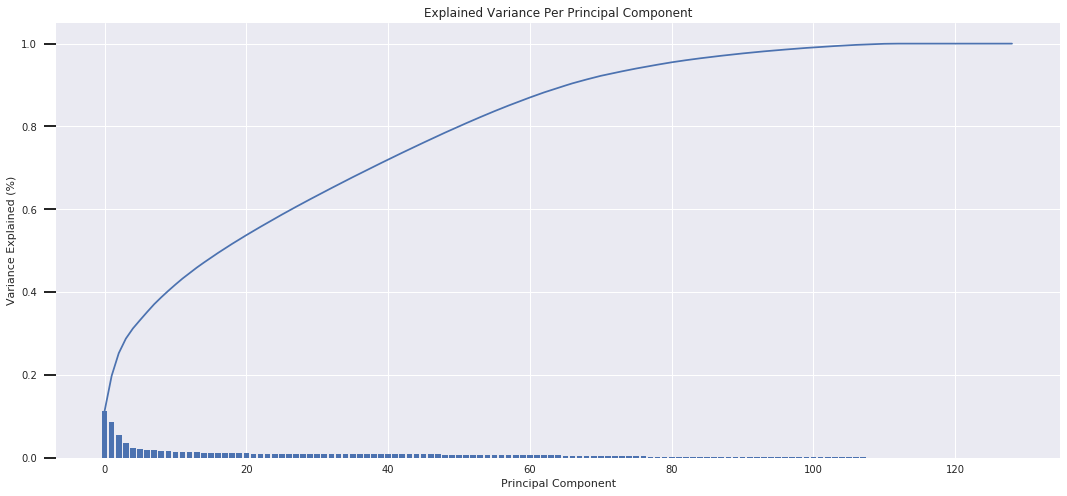

In [83]:
scree_plot(pca, show_labels=False)

In [108]:
# the above screeplot - we see that around 40 pricipal component
# we see having more principal components - the rate at which cumulative variance increases a slows down there after 
for i in np.arange(10, 70, 5):
    print('{} components explain {} of variance.'.format(i, pca.explained_variance_ratio_[:i].sum()))

10 components explain 0.40331934521178303 of variance.
15 components explain 0.4711628870275462 of variance.
20 components explain 0.526715391447435 of variance.
25 components explain 0.5764967474235212 of variance.
30 components explain 0.6224499958624515 of variance.
35 components explain 0.6661800513349668 of variance.
40 components explain 0.7079117537811908 of variance.
45 components explain 0.7079117537811908 of variance.
50 components explain 0.7079117537811908 of variance.
55 components explain 0.7079117537811908 of variance.
60 components explain 0.7079117537811908 of variance.
65 components explain 0.7079117537811908 of variance.


In [115]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=40)
azdias_pca = pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [134]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

#draw plot for visualizing those weights
def plot_pca_components(data, pca, no_component):
    '''
    Plot features_no features with the most positive and negative variance
    for a component_no PCA component
    '''
    pca_component = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[no_component-1]
    # the most interesting features will be those at the start and end of sorted list
    pca_component.sort_values(ascending=False, inplace=True)
    pca_component = pd.concat([pca_component.head(5), pca_component.tail(5)]) 
    
    pca_component.plot(kind='bar', 
                       title=f'Top 10 weighted features for PCA component {no_component}',
                      figsize=(12, 6))
    plt.show()
    print(f'Top features mapped to Principal component: {no_component}')
    print(pca_component)

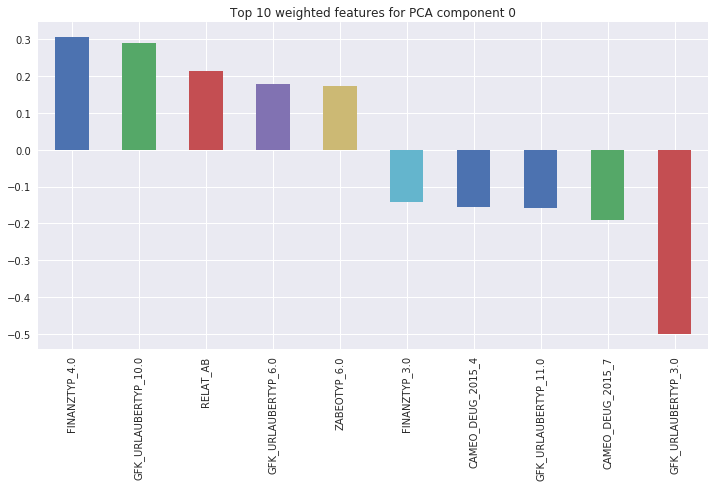

Top features mapped to Principal component: 0
FINANZTYP_4.0           0.3062
GFK_URLAUBERTYP_10.0    0.2908
RELAT_AB                0.2157
GFK_URLAUBERTYP_6.0     0.1781
ZABEOTYP_6.0            0.1741
FINANZTYP_3.0          -0.1431
CAMEO_DEUG_2015_4      -0.1548
GFK_URLAUBERTYP_11.0   -0.1588
CAMEO_DEUG_2015_7      -0.1902
GFK_URLAUBERTYP_3.0    -0.5000
Name: 39, dtype: float64


In [135]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_components(data=azdias_clean, pca=pca, no_component=0)

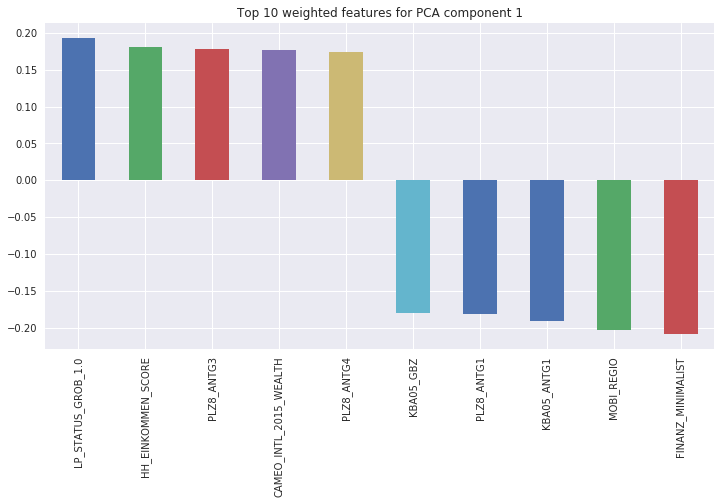

Top features mapped to Principal component: 1
LP_STATUS_GROB_1.0        0.1933
HH_EINKOMMEN_SCORE        0.1807
PLZ8_ANTG3                0.1785
CAMEO_INTL_2015_WEALTH    0.1772
PLZ8_ANTG4                0.1735
KBA05_GBZ                -0.1798
PLZ8_ANTG1               -0.1809
KBA05_ANTG1              -0.1913
MOBI_REGIO               -0.2033
FINANZ_MINIMALIST        -0.2092
Name: 0, dtype: float64


In [136]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_components(data=azdias_clean, pca=pca, no_component=1)

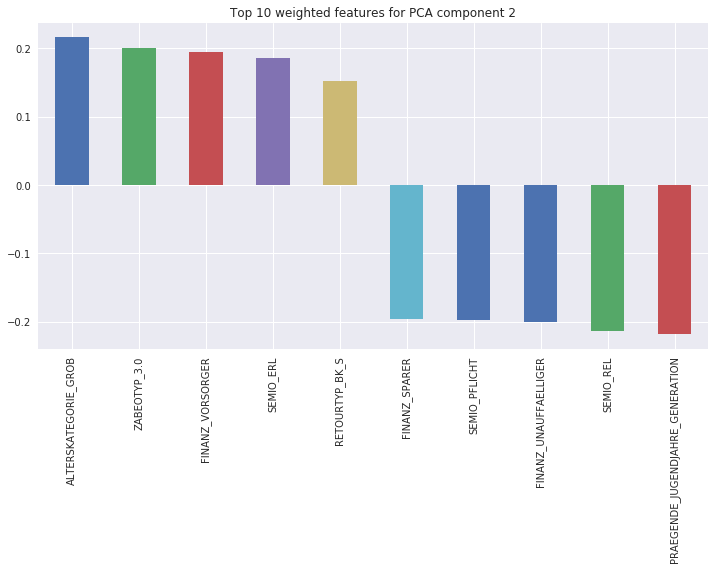

Top features mapped to Principal component: 2
ALTERSKATEGORIE_GROB                0.2156
ZABEOTYP_3.0                        0.1996
FINANZ_VORSORGER                    0.1949
SEMIO_ERL                           0.1851
RETOURTYP_BK_S                      0.1517
FINANZ_SPARER                      -0.1961
SEMIO_PFLICHT                      -0.1973
FINANZ_UNAUFFAELLIGER              -0.2008
SEMIO_REL                          -0.2129
PRAEGENDE_JUGENDJAHRE_GENERATION   -0.2178
Name: 1, dtype: float64


In [137]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_components(data=azdias_clean, pca=pca, no_component=2)

### Discussion 2.3: Interpret Principal Components


**Top Features for First Principal Component** 

is positively related to :
- FINANZTYP_4.0           Financial Type for individual (be prepared)
- GFK_URLAUBERTYP_10.0    Vacation habits  (Connoisseurs
- RELAT_AB                Share of unemployment relative to county in which community is contained
- GFK_URLAUBERTYP_6.0     Vacation habits (Hikers)
- ZABEOTYP_6.0            Energy consumption typology (indifferent)

is negatively related to :
- FINANZTYP_3.0          Finacial Type for individual (home ownership)
- CAMEO_DEUG_2015_4       Wealth / Life Stage Typology (consumption-oriented middleclass)
- GFK_URLAUBERTYP_11.0    Vacation habits (Active families)
- CAMEO_DEUG_2015_7      Wealth / Life Stage Typology (lower middleclass)
- GFK_URLAUBERTYP_3.0    Vacation habits (Winter sportspeople)

_Meaningful interpretation : The first component is generally related to Person level, RR4 micro-cell and Community-level features_


**Top Features for Second Principal Component** 

is positively related to :
- LP_STATUS_GROB_1.0        Social status (low-income earners)
- HH_EINKOMMEN_SCORE        Estimated household net income
- PLZ8_ANTG3                Number of 6-10 family houses in the PLZ8 region 
- CAMEO_INTL_2015_WEALTH    Wealth level
- PLZ8_ANTG4                Number of 6-10 family houses in the PLZ8 region

is negatively related to :
- KBA05_GBZ                Number of buildings in the microcell
- PLZ8_ANTG1               Number of 1-2 family houses in the PLZ8 region
- KBA05_ANTG1              Number of 1-2 family houses in the microcell
- MOBI_REGIO               Movement patterns
- FINANZ_MINIMALIST        Financial typology (low financial interest)

_Meaningful interpretation : The second component is generally related to Person level, Household level, 
RR4 micro-cell, RR3 micro-cell, RR1 neighborhood and PLZ8 macro-cell features_

**Top Features for Third Principal Component** 

is positively related to :
- ALTERSKATEGORIE_GROB                Estimated age based on given name analysis
- ZABEOTYP_3.0                        Energy consumption typology (fair supplied)
- FINANZ_VORSORGER                    Financial typology (be prepared)
- SEMIO_ERL                           Personality typology (event-oriented)
- RETOURTYP_BK_S                      Return type 

is negatively related to :
- FINANZ_SPARER                      Financial typology (money-saver)
- SEMIO_PFLICHT                      Personality typology (dutiful)
- FINANZ_UNAUFFAELLIGER              Financial typology (inconspicuous)
- SEMIO_REL                          Personality typology (religious)
- PRAEGENDE_JUGENDJAHRE_GENERATION   Persons Generation (40s, 50s, 60s, 70s, 80s, 90s)

_Meaningful interpretation : The third component is generally related to Person level attributes_


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [139]:
# to reduce on computation time we will sample a 'toy' data set to perform clustering with
# with 20% of our data
azdias_pca_sample = azdias_pca[np.random.choice(azdias_pca.shape[0], int(azdias_pca.shape[0]*0.2), replace=False)]

In [142]:
# Over a number of different cluster counts...
k_range = np.arange(10, 31)
sse = [] # list of squared sum errors
for k in k_range:
    # run k-means clustering on the data and...
    kmeans = KMeans(k, random_state=1234, max_iter=30, n_jobs=-1).fit(azdias_pca_sample)
    score = np.abs(kmeans.score(azdias_pca_sample))
    # compute the average within-cluster distances.
    sse.append(score)
    print('Clustering done for {} k, with SSE {}'.format(k, score))
    

Clustering done for 10 k, with SSE 7494365.450576126
Clustering done for 11 k, with SSE 7409536.460923156
Clustering done for 12 k, with SSE 7319022.856389881
Clustering done for 13 k, with SSE 7251007.4926520875
Clustering done for 14 k, with SSE 7177432.779693183
Clustering done for 15 k, with SSE 7120192.600056072
Clustering done for 16 k, with SSE 7069580.534537986
Clustering done for 17 k, with SSE 6969973.121484899
Clustering done for 18 k, with SSE 6921764.089028785
Clustering done for 19 k, with SSE 6871990.122279846
Clustering done for 20 k, with SSE 6838976.250099088
Clustering done for 21 k, with SSE 6787275.640263704
Clustering done for 22 k, with SSE 6746557.679950862
Clustering done for 23 k, with SSE 6716061.0836920515
Clustering done for 24 k, with SSE 6678590.511683882
Clustering done for 25 k, with SSE 6648065.581788852
Clustering done for 26 k, with SSE 6612963.332312652
Clustering done for 27 k, with SSE 6578416.2182334075
Clustering done for 28 k, with SSE 6558517.

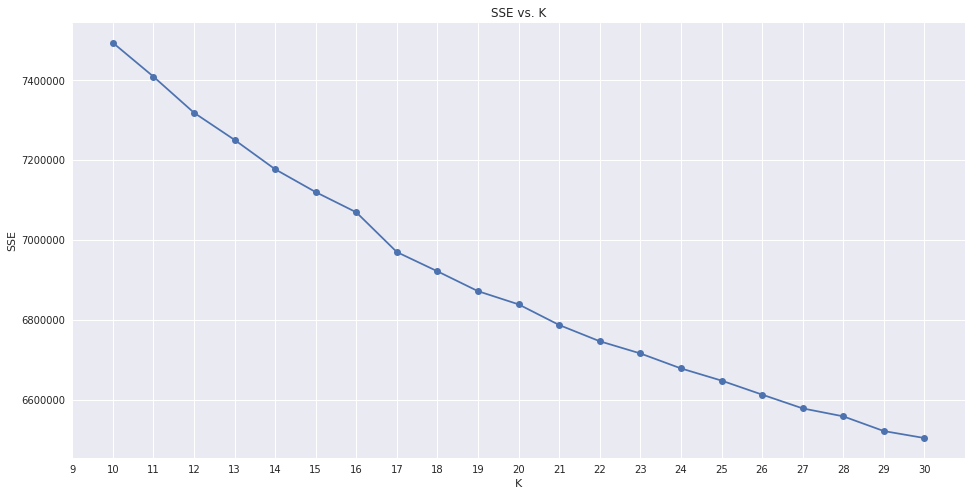

In [145]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# using the Elbow Method to identify the right value of k
plt.figure(figsize=(16, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.plot(k_range, sse, linestyle='-', marker="o");

In [146]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k = 17
kmeans = KMeans(k, random_state=1234, max_iter=30, n_jobs=-1).fit(azdias_pca)
population_clusters = kmeans.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

We generated a 'toy' dataset by randomly choosing 20% of our clean data - then used the Elbow method to identify the suitable number of clusters. The plot did not show a dramatic change with different number of cluster but around 17 cluster the plot gradient shows a change where with higher number of clusters the rate of change is lower. So we chose to use 17 clusters to segment the population.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [212]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [152]:
customers.shape # number of rows ond columns

(191652, 85)

In [150]:
# lets see some sample of customer data
customers.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [213]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Apply Preprocessing - feature wrangling, selection, and engineering steps 
customers_clean = clean_data(customers)

In [208]:
customers_clean.head(5) # cleaned customer data

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X,PRAEGENDE_JUGENDJAHRE_GENERATION,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,4,1,5,1,5,1,2,2,0,1,...,0,0,0,0,0,0,1.0,1,1.0,3.0
2,4,2,5,1,5,1,4,4,0,1,...,1,0,0,0,0,0,1.0,1,3.0,4.0
3,4,1,5,1,5,2,1,2,0,0,...,0,0,0,0,0,0,0.0,0,2.0,4.0
4,3,1,3,1,4,4,5,2,1960,0,...,0,0,1,0,0,0,3.0,0,4.0,1.0
5,3,1,5,1,5,1,2,3,0,1,...,1,0,0,0,0,0,1.0,1,3.0,4.0


In [214]:
## Apply transformations - remove remaining missing variables
customers_clean.dropna(inplace=True)

In [216]:
## Scale the data - standardize the data
customers_scaled = scaler.fit_transform(customers_clean)

In [219]:
# Apply Principal Components
customers_pca = pca.fit_transform(customers_scaled)

In [220]:
# Cluster the data 
k = 17
kmeans = KMeans(k, random_state=1234, max_iter=30, n_jobs=-1).fit(customers_pca)
customer_clusters = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [221]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
population_clusters = pd.Series(population_clusters)
popc = population_clusters.value_counts().sort_index()
popc = pd.Series(popc)

customer_clusters = pd.Series(customer_clusters)
custc = customer_clusters.value_counts().sort_index()
custc = pd.Series(custc)


In [223]:
# Create a dataset summarizing clustering information
pop_cust = pd.concat([popc, custc], axis=1).reset_index()
pop_cust.columns = ['cluster', 'population', 'customers']

# Calculate proprotions
pop_cust['cust_prop'] = pop_cust['customers'] / pop_cust['customers'].sum()
pop_cust['pop_prop'] = pop_cust['population'] / pop_cust['population'].sum()
pop_cust

,cluster,population,customers,cust_prop,pop_prop
0,0,2813,2638,0.021524,0.004514
1,1,38469,10696,0.087271,0.061727
2,2,43482,10432,0.085117,0.069771
3,3,39040,12561,0.102488,0.062643
4,4,29710,6117,0.049910,0.047672
5,5,46742,1957,0.015968,0.075002
6,6,41571,5891,0.048066,0.066705
7,7,52576,1518,0.012386,0.084363
8,8,33306,7118,0.058077,0.053443
9,9,40354,3545,0.028924,0.064752


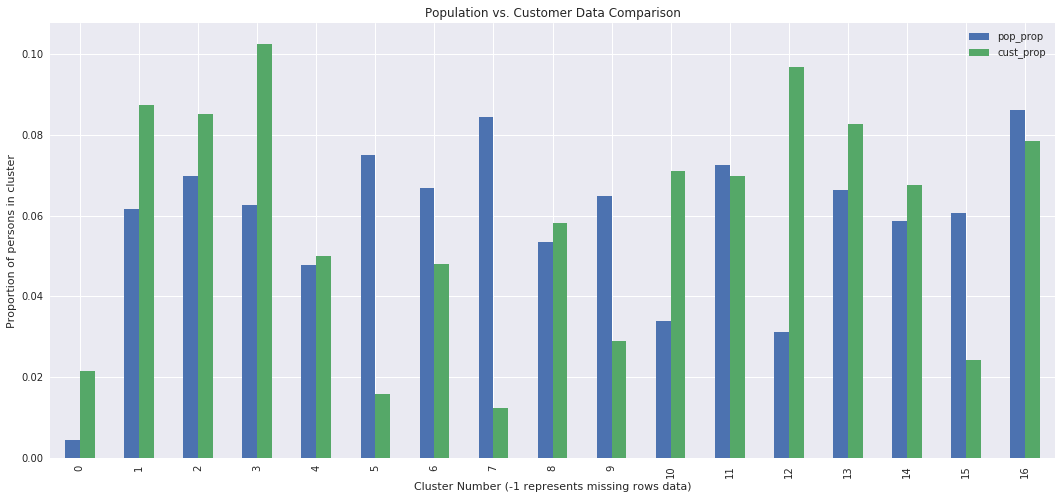

In [224]:
# Compare visually
pop_cust.plot(x='cluster', y=['pop_prop', 'cust_prop'], kind='bar', figsize=(18, 8))
plt.title('Population vs. Customer Data Comparison')
plt.xlabel('Cluster Number (-1 represents missing rows data)')
plt.ylabel('Proportion of persons in cluster')
plt.show()

In [225]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Cluster 12

# Looking at cluster 12- lets get the 5 top principal components of cluster 12
pc12 = kmeans.cluster_centers_[12]
pc12 = pd.Series(pc12)
pc12.sort_values(ascending=False, inplace=True)
pc12.head(5)

2     2.485123
3     1.094373
7     0.651412
25    0.311030
8     0.295150
dtype: float64

In [226]:
# Lets; transform cluster 12 to the original feature values
pc12 = scaler.inverse_transform(pca.inverse_transform(pc12))
pc12 = pd.Series(pc12).round()
pc12.index = customers_clean.columns
pc12

ALTERSKATEGORIE_GROB                  3.0
ANREDE_KZ                             1.0
FINANZ_MINIMALIST                     4.0
FINANZ_SPARER                         2.0
FINANZ_VORSORGER                      4.0
FINANZ_ANLEGER                        2.0
FINANZ_UNAUFFAELLIGER                 2.0
FINANZ_HAUSBAUER                      3.0
GEBURTSJAHR                         988.0
GREEN_AVANTGARDE                      0.0
HEALTH_TYP                            2.0
RETOURTYP_BK_S                        3.0
SEMIO_SOZ                             4.0
SEMIO_FAM                             4.0
SEMIO_REL                             3.0
SEMIO_MAT                             4.0
SEMIO_VERT                            5.0
SEMIO_LUST                            5.0
SEMIO_ERL                             5.0
SEMIO_KULT                            4.0
SEMIO_RAT                             3.0
SEMIO_KRIT                            4.0
SEMIO_DOM                             4.0
SEMIO_KAEM                        

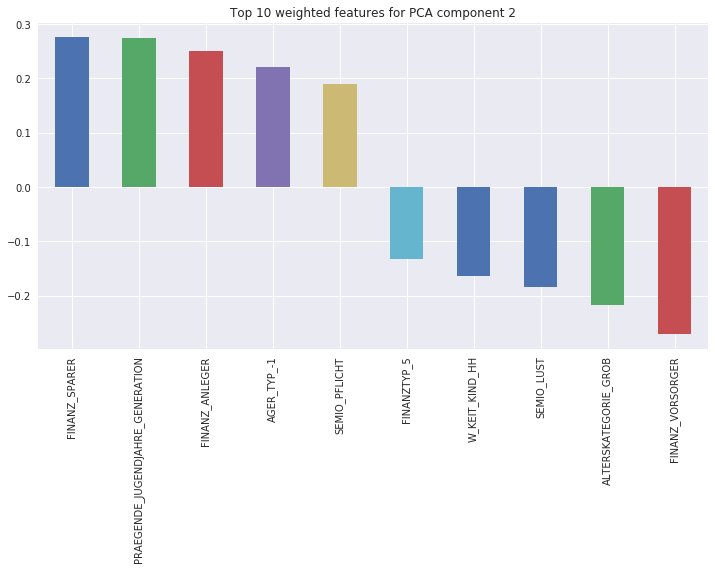

Top features mapped to Principal component: 2
FINANZ_SPARER                       0.2753
PRAEGENDE_JUGENDJAHRE_GENERATION    0.2751
FINANZ_ANLEGER                      0.2502
AGER_TYP_-1                         0.2214
SEMIO_PFLICHT                       0.1889
FINANZTYP_5                        -0.1316
W_KEIT_KIND_HH                     -0.1642
SEMIO_LUST                         -0.1846
ALTERSKATEGORIE_GROB               -0.2180
FINANZ_VORSORGER                   -0.2705
Name: 1, dtype: float64


In [228]:
# Checking 5 top principal components of cluster 12
plot_pca_components(data=customers_clean, pca=pca, no_component=2)

In [229]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# cluster 7

# Looking at cluster 7- lets get the 5 top principal components of cluster 7
pc7 = kmeans.cluster_centers_[7]
pc7 = pd.Series(pc7)
pc7.sort_values(ascending=False, inplace=True)
pc7.head(5)

4    15.081434
0     2.518910
6     2.341439
1     2.153632
3     1.530818
dtype: float64

In [230]:
# Lets; transform cluster 7 to the original feature values
pc7 = scaler.inverse_transform(pca.inverse_transform(pc7))
pc7 = pd.Series(pc12).round()
pc7.index = customers_clean.columns
pc7

ALTERSKATEGORIE_GROB                  3.0
ANREDE_KZ                             1.0
FINANZ_MINIMALIST                     4.0
FINANZ_SPARER                         2.0
FINANZ_VORSORGER                      4.0
FINANZ_ANLEGER                        2.0
FINANZ_UNAUFFAELLIGER                 2.0
FINANZ_HAUSBAUER                      3.0
GEBURTSJAHR                         988.0
GREEN_AVANTGARDE                      0.0
HEALTH_TYP                            2.0
RETOURTYP_BK_S                        3.0
SEMIO_SOZ                             4.0
SEMIO_FAM                             4.0
SEMIO_REL                             3.0
SEMIO_MAT                             4.0
SEMIO_VERT                            5.0
SEMIO_LUST                            5.0
SEMIO_ERL                             5.0
SEMIO_KULT                            4.0
SEMIO_RAT                             3.0
SEMIO_KRIT                            4.0
SEMIO_DOM                             4.0
SEMIO_KAEM                        

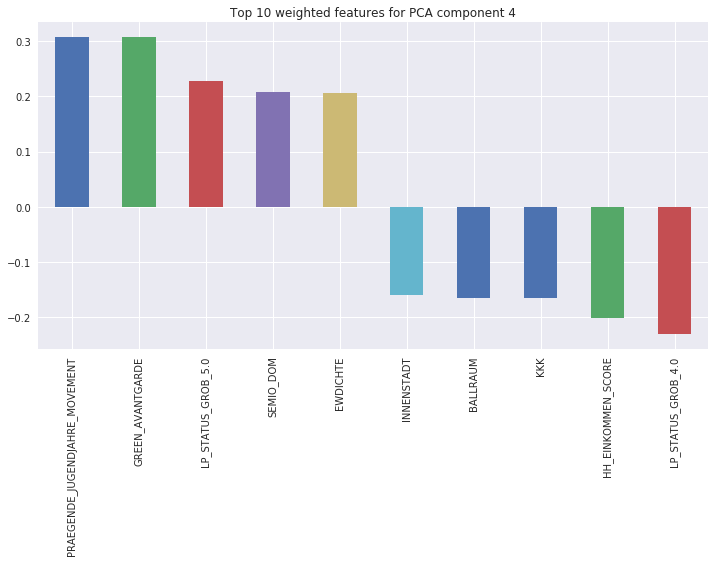

Top features mapped to Principal component: 4
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.3071
GREEN_AVANTGARDE                  0.3071
LP_STATUS_GROB_5.0                0.2286
SEMIO_DOM                         0.2078
EWDICHTE                          0.2058
INNENSTADT                       -0.1594
BALLRAUM                         -0.1649
KKK                              -0.1656
HH_EINKOMMEN_SCORE               -0.2007
LP_STATUS_GROB_4.0               -0.2295
Name: 3, dtype: float64


In [231]:
# Checking 5 top principal components of cluster 7
plot_pca_components(data=customers_clean, pca=pca, no_component=4)

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)


**Top features mapped to Principal component: for cluster 12**
FINANZ_SPARER                       Financial typology(money-saver)
PRAEGENDE_JUGENDJAHRE_GENERATION    Person's Generation (40s to 90s)
FINANZ_ANLEGER                      Financial typology (investor)
AGER_TYP_-1                         Best-ager typology (unknown)
SEMIO_PFLICHT                       Personality typology (dutiful)
FINANZTYP_5                         Most descriptive financial type for individual (investor)
W_KEIT_KIND_HH                      Likelihood of children in household
SEMIO_LUST                          Personality typology(sensual-minded)
ALTERSKATEGORIE_GROB               Estimated age based on given name analysis
FINANZ_VORSORGER                   Financial typology (be prepared)

Cluster 12 is one of the clusters overrepresented in the customer data compared to the general population. Looking at most  influencing components and their weights, it the cluster has older individual who are money savers and investors, living with  children - they are dutiful to households are therefore less likely to change their shopping habits.


**Top features mapped to Principal component: for cluster 7**
PRAEGENDE_JUGENDJAHRE_MOVEMENT    Person's movement (avantgarde or mainstream)
GREEN_AVANTGARDE                  Membership in environmental sustainability as part of youth
LP_STATUS_GROB_5.0                Social status (top earners)
SEMIO_DOM                         Personality typology (dominant-minded)
EWDICHTE                          Density of households per square kilometer
INNENSTADT                        Distance to city center (downtown)
BALLRAUM                          Distance to nearest urban center
KKK                              Purchasing power in region
HH_EINKOMMEN_SCORE               Estimated household net income
LP_STATUS_GROB_4.0               Social status (houseownders)

Cluster 7 is one of the clusters underrepresented in the customer data compared to the general population. Looking at most  influencing components and their weights, it the cluster has people with higher incomes, higher purchasing power and care about their environment - they would be more flexible and hence more likely to go for a newer way to shop instead of going to the shopping mall.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.